In [54]:
import qtensor
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import networkx as nx
from cartesian_explorer import parallels, dict_product
import xarray

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.2),  # slightly white
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  # transparent
})

/tmp/ipykernel_30306/2095954017.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Some preliminary demos

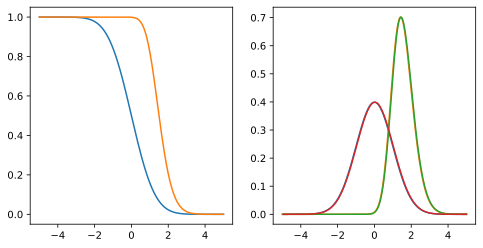

In [21]:
N = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
x = np.linspace(-5, 5, 200)
errf = sc.special.erf(x/np.sqrt(2))/2+1/2
gaus = sc.stats.norm.pdf(x)
plt.sca(ax1)
plt.plot(x, 1 - errf)
plt.plot(x, 1 - errf**N)

plt.sca(ax2)
plt.plot(x, gaus)
plt.plot(x, N*errf**(N-1)*gaus)
ern = errf**N
plt.plot(x[1:], (ern[1:]-ern[:-1])/(x[1:]-x[:-1]))
plt.plot(x[1:], (errf[1:]-errf[:-1])/(x[1:]-x[:-1]))


In [22]:
def approx_ratio(p):
    ps = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 12)]
    AR = ps[p-1]
    if AR>0:
        return AR
    else:
        raise KeyError

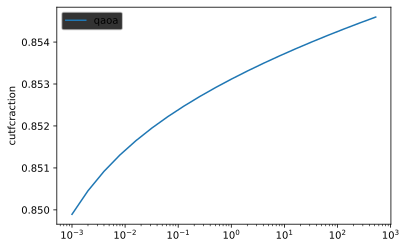

In [23]:
def get_E_N(N, sigma=1):
    x = np.linspace(-6, 6, 200)
    errf = sc.special.erf(x/sigma/np.sqrt(2))/2+1/2
    gaus = sc.stats.norm.pdf(x, scale=sigma)
    pdf = N*errf**(N-1)*gaus
    mean = np.mean(pdf*x)
    return mean

mean_qaoa = approx_ratio(6)
variance_qaoa_16 = 0.0023
Ns = 2**np.arange(0, 20)
En = [get_E_N(N, sigma=1)*np.sqrt(variance_qaoa_16)*4/np.sqrt(256) + mean_qaoa for N in Ns]
plt.plot(Ns/1000, En, label=f'qaoa')
#plt.plot(Ns, np.log(Ns)/10, '--', label='log')
#plt.plot(Ns/100, np.sqrt(2*np.log(Ns))*variance_qaoa+mean_qaoa, '--', label='bound')
plt.ylabel('cutfcraction')
plt.xscale('log')
plt.legend()

## Actual data collection

In [43]:
def get_maxcut_samples(N, p=6, nsamples=1000, graph_seed=0):
    G = nx.random_regular_graph(3, N, seed=graph_seed)
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer)
    gammabeta = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    comp = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    comp.ansatz_state()
    circ = comp.circuit
    sim.optimizer = qtensor.toolbox.get_ordering_algo('naive')
    amps = sim.simulate_batch(circ, batch_vars=range(G.number_of_nodes()))
    probs = np.real(amps.conj()*amps)
    samples_int = np.random.choice(range(2**N), size=nsamples, p=probs/sum(probs))
    samples = np.array(np.unravel_index(samples_int, shape=[2]*N))*2-1
    e = G.number_of_edges()
    costs = [(e-sum(sol[comp.qubits[i]]*sol[comp.qubits[j]] for i,j in G.edges))/2 for sol in samples.T]
    return np.array(costs)/e


In [48]:
costs = get_maxcut_samples(20, p=2)

Stddev for costs 0.06608314627968485


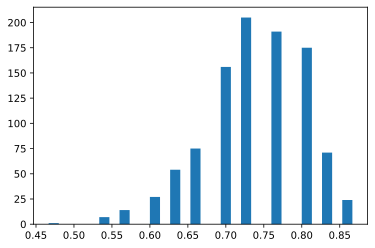

In [49]:
plt.hist(costs, bins=30)
print('Stddev for costs', np.std(costs))

In [31]:
costs = get_maxcut_samples(22)

Stddev for costs 0.03997215513841541


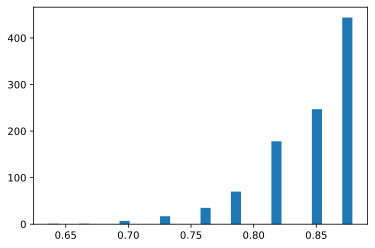

In [32]:
plt.hist(costs, bins=30)
print('Stddev for costs', np.std(costs))

In [55]:
dims = dict(
    N=[8, 12, 16],
    graph_seed=range(5),
    p=[3, 4, 5, 6],
    nsamples=[1000]
)
params = list(dict_product(**dims))
print("Params len", len(params))
print("Data estimate size", len(params)*1000*8/1e6, 'MB')

Params len 60
Data estimate size 0.48 MB


In [56]:
parallel = parallels.Ray(processes=55)

2021-12-12 03:27:34,203	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


In [52]:
data = parallel.starstarmap(get_maxcut_samples, params)

In [78]:
data_reshaped = np.array(data).reshape(*[len(x) for x in dims.values()]+[1000])
dims_xr = list(dims.keys()) + ['sample']
coords = {**dims, 'sample':range(1000)}
xda = xarray.DataArray(data=data_reshaped, coords=coords, dims=dims_xr)

### Data sanity check

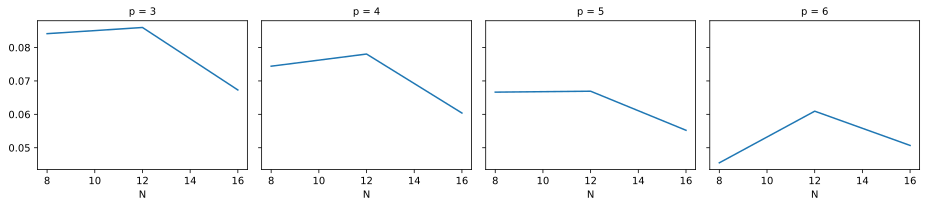

In [80]:
xda.std('sample').mean('graph_seed').plot(x='N', col='p', )

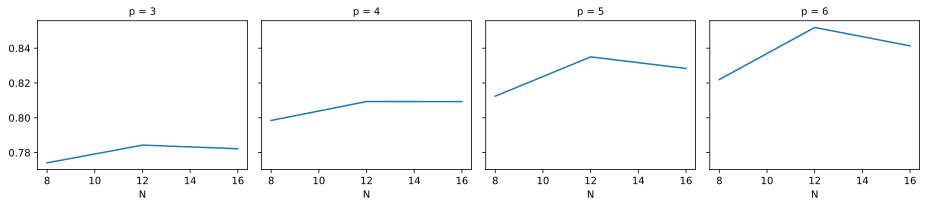

In [83]:
xda.mean('sample').mean('graph_seed').plot(x='N', col='p', )

In [82]:
xda.to_netcdf('../qaoa_variance_nsamples1000.nc')